In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import regex as re

from nltk.corpus import stopwords
# Need to uncomment the following line in order to download nltk stopwords:
# nltk.download('stopwords')
import spacy
from textacy.extract import keyword_in_context

from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

plt.style.use(style='seaborn')
%matplotlib inline
sns.set()

# Import data set:

In [2]:
pd.options.mode.chained_assignment = None

with open('data/dk_asylum_data.json', encoding='utf-8') as inputfile:
    df_full = pd.read_json(inputfile)

# Convert json to csv:
df_full.to_csv('data/dk_asylum_data.csv', encoding='utf-8', index=False)

df_full.shape


(9324, 5)

## Keep ALL cases EXCEPT for Unknown Homeland (Ukendt hjemland):

In [3]:
df_ALL = df_full[df_full.country != "Ukendt hjemland"]

# Drop redundant column:
df_ALL.drop('hasText', axis=1, inplace=True)

# Keep column 'text':
df = df_ALL[['text']]

df["text"] = df["text"].astype(str)

df.shape

#df.head()


(9132, 1)

## Length of texts

Create a numeric column in order to get a feel about the length of the texts. 

In [4]:
df['length'] = df['text'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,9132.0,4178.451051,2169.105671,407.0,2677.0,3814.5,5208.25,22106.0


## Boxplot:

<AxesSubplot:>

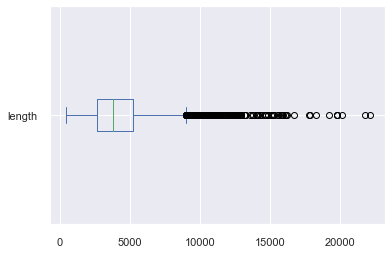

In [5]:
# Box plot:
df['length'].plot(kind='box', vert=False)

## Histogram:

<AxesSubplot:ylabel='Frequency'>

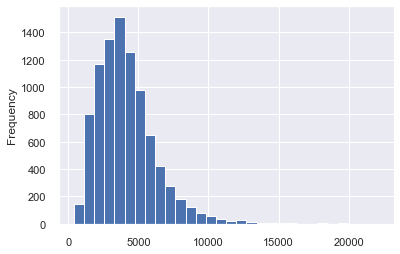

In [6]:
# Histogram:
df['length'].plot(kind='hist', bins=30)


# Create a pipeline:

Below are the steps taken to process the texts.

In [7]:
stopwords_lower = list(map(lambda x: x.lower(), stopwords.words('danish')))

STOPWORDS_DANISH = set(stopwords_lower)

nlp = spacy.load("da_core_news_sm")

PUNCTUATION_TO_REMOVE = '–«!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~»●·’“”'


def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCTUATION_TO_REMOVE))


def remove_stopwords(tokens):
    """custom function to remove stopwords"""
    return [t for t in tokens if t.lower() not in STOPWORDS_DANISH]


def tokenize(text):
    """the following expression matches tokens consisting of at least one letter (\p{L}), 
    preceded and followed by an arbitrary sequence of alphanumeric characters 
    (\w includes digits, letters, and underscore) and hyphens (-)"""
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)


def drop_single_letter_words(text):
    return [w for w in text if len(w) > 1]


def lemmatize(text):
    """custom function to lemmatize text"""
    doc = nlp(' '.join(text))
    # pos_tagged_text = text.pos
    return [token.lemma_ for token in doc]


# def remove_junk(text):
#     # Creating a spacy object
#     doc = nlp(' '.join(text))
#     # Checking if POS tag is X and printing them
#     for token in doc:
#         if token.pos_ == 'X':
#             print(token.text)
#     # Removing the tokens whose POS tag is junk.
#     clean_doc = [token.text for token in doc if not token.pos_ == 'X']

#     return clean_doc


Steps can be added or removed from the pipeline.

In [8]:
pipeline = [str.lower, remove_punctuation, tokenize,
            drop_single_letter_words, remove_stopwords, lemmatize]


def process(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


In [9]:
# Apply the process pipeline:
df['tokens'] = df['text'].apply(process, pipeline=pipeline)

# Add column to see the number of tokens:
df['num_tokens'] = df['tokens'].map(len)

In [10]:
df.head()

,text,length,tokens,num_tokens
0,Nævnet stadfæstede i marts 2022 Udlænd...,3046,"[nævn, stadfæste, marts, udlændingestyrelse, a...",240
1,Nævnet stadfæstede i marts 2022 Udlænd...,2437,"[nævn, stadfæste, marts, udlændingestyrelse, a...",189
2,Nævnet stadfæstede i marts 2022 Udlænd...,2754,"[nævn, stadfæste, marts, udlændingestyrelse, a...",221
3,Nævnet stadfæstede i marts 2022 Udlænd...,2934,"[nævn, stadfæste, marts, udlændingestyrelse, a...",237
4,Nævnet stadfæstede i marts 2022 Udlænd...,5252,"[nævn, stadfæste, marts, udlændingestyrelse, a...",404


# Frequency analysis:

Here we count the most frequent tokens in the **whole** corpus.


In [11]:
# Transform the counter into a Pandas DataFrame with the following function:

"""
The tokens make up the index of the DataFrame, while the frequency values are stored in a column named freq. 
The rows are sorted so that the most frequent words appear at the head.
The last parameter of count_words defines a minimum frequency of tokens to be included in the result. 
Its default is set to 2 to cut down on tokens occurring only once.
"""

def count_words(df, column='tokens', preprocess=None, min_freq=2):
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    # create counter and run through all data
    counter = Counter() 
    df[column].map(update)
    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq']) 
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

In [12]:
# See ten most frequent words in the whole corpus:

freq_df = count_words(df) 
freq_df.head(10)

,freq
token,
ansøger,187044
flygtningenævn,59005
klager,40958
vide,33302
finde,28045
forklare,26174
stk,26042
nævn,25539
udlændingelov,24550


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

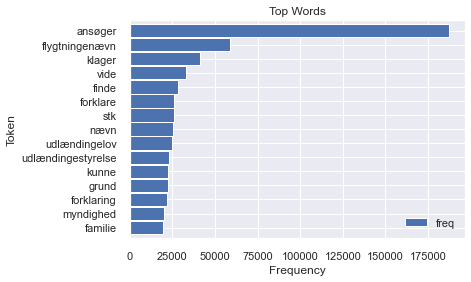

In [13]:
# Plot the results:
ax = freq_df.head(15).plot(kind='barh', width=0.95) 
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# TF-IDF Ranking:

Rank tokens based on their TF-IDF score.

In [14]:
"""
Each token is counted only once per document (counter.update(set(tokens))), 
and the IDF values are computed after counting. 
The parameter min_df serves as a filter for the long tail of infrequent words. 
The result of this function is a DataFrame.
"""

def compute_idf(df, column='tokens', preprocess=None, min_df=2):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc) 
        counter.update(set(tokens))
        # count tokens
    counter = Counter() 
    df[column].map(update)
        # create DataFrame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df']) 
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [15]:
# Create a DataFrame containing the IDF values for each token (idf_df):

idf_df = compute_idf(df)

# Both the IDF and the frequency DataFrame have an index consisting of the tokens, 
# we can simply multiply the columns of both DataFrames to calculate the TF-IDF score for the terms:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']


In [16]:
# Sort values based on their score:
freq_df = freq_df.sort_values('tfidf', ascending=False)

# See the top 15:
freq_df.head(15)

,freq,tfidf
token,,
klager,40958,73878.526274
ansøger,187044,44984.339127
iran,12248,19146.108399
afghanistan,10683,18346.487665
ansøge,10019,18248.265099
somalia,7057,17184.380343
syrien,7561,15725.970198
irak,8613,15582.578532
far,12538,15252.619197


[Text(0.5, 0, 'Weights'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Top 15 Words based on TF-IDF Ranking')]

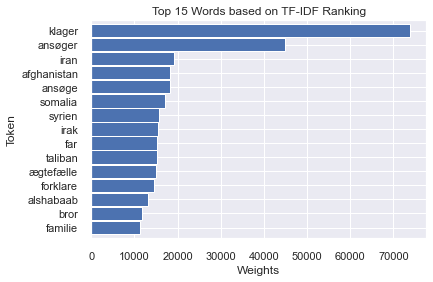

In [17]:
# Plot the results:
ax_tf_idf = freq_df['tfidf'].head(15).plot(kind='barh', width=0.95) 
ax_tf_idf.invert_yaxis()
ax_tf_idf.set(xlabel='Weights', ylabel='Token', title='Top 15 Words based on TF-IDF Ranking')

# Keyword in context (KWIC):

KWIC analysis produces a list of text fragments of equal length showing the left and right context of a keyword.

In [18]:
"""
The function iteratively collects the keyword contexts by applying the add_kwic function to each document with map. 
By default, the function returns a list of tuples of the form (left context, keyword, right context). 
If print_samples is greater than 0, a random sample of the results is printed. 
Sampling is especially useful with lots of documents because the first entries of the list 
would otherwise stem from a single or a very small number of documents.
"""

def kwic(doc_series, keyword, window=35, print_samples=5):
    def add_kwic(text):
        kwic_list.extend(keyword_in_context(text, keyword, ignore_case=True, window_width=window))

    kwic_list = []
    doc_series.map(add_kwic)

    if print_samples is None or print_samples == 0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f'{k} random samples out of {len(kwic_list)} ' +
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0]) + ' ' +
                  sample[1]+' ' +
                  re.sub(r'[\n\t]', ' ', sample[2]))


Bellow we apply KWIC for `stk` keyword found from the frequency analysis and print 10 random context appearances.

The call is made to the original untokenized & unprocessed dataset.

In [19]:
kwic(df['text'], 'stk', print_samples=10)

10 random samples out of 26202 contexts for 'stk':
lgelse efter udlændingelovens § 7,  stk . 1. Den kvindelige ansøger, der ik
 omfattet af udlændingelovens § 7,  stk . 2, ved en tilbagevende til Iran. 
 omfattet af udlændingelovens § 7,  stk . 1, eller i risiko for at blive ud
§ 7, stk. 1, subsidiært efter § 7,  stk . 2 grundet individuelle forhold. K
sylland, jf. udlændingelovens § 7,  stk . 4. Flygtningenævnet stadfæster de
medfør af udlændingelovens § 48 a,  stk . 1, 1. pkt., jf. § 29 a, stk. 1, j
 omfattet af udlændingelovens § 7,  stk . 1. Det bemærkes imidlertid, at an
jf. Dublinforordningens artikel 3,  stk . 2, 2. led. De anførte forhold – h
i medfør af udlændingelovens § 17,  stk . 1, jf. § 17, stk. 4, jf. § 17 a, 
estemmelse i udlændingelovens § 7,  stk . 2. Ansøgeren var på tidspunktet f


# N-gram analysis:

In [20]:
"""
Create the bigrams on all tokens but keep only those that do not contain any stop words.
"""

def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)]) 
            if len([t for t in ngram if t in stopwords]) == 0]


Add a column to the dataset containing all 'bigrams'.

Then apply `count_words` in order to determing the 10 most popular ones.

In [21]:
df['bigrams'] = df['text'].apply(process, pipeline=[str.lower, tokenize]).apply(ngrams, n=2, stopwords=STOPWORDS_DANISH)

count_words(df, 'bigrams').head(10)

,freq
token,
udlændingelovens stk,18701
udlændingestyrelsens afgørelse,12901
flygtningenævnet finder,10268
ansøgerens forklaring,10076
asylmotiv henvist,8353
lagt vægt,7986
flygtningenævnet udtalte,7964
nævnet stadfæstede,6567
politisk aktiv,6552
